Ctrl+LeftArrow: Moves the cursor left by one "word" (in quotes, because it may not be a complete word, e.g., check-in).

Ctrl+RightArrow: Moves the cursor right by one "word".

Ctrl+Shift+LeftArrow: Moves the cursor left by one "word", while selecting what the cursor passed over.

Ctrl+Shift+RightArrow: Moves the cursor right by one "word", while selecting what the cursor passed over.

Ctrl+Backspace: Deletes the "word" immediately to the left.

Ctrl+c: Copies.

Ctrl+v: Pastes.

Ctrl+x: Cuts.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math

In [2]:
is_kaggle = False

if is_kaggle:
    base_dir = '/kaggle/input'
    data_dir = f'{base_dir}/linking-writing-processes-to-writing-quality'
    output_dir = '/kaggle/working'
else:
    base_dir = '../'
    data_dir = f'{base_dir}/data'
    models_dir = f'{base_dir}/models'

In [3]:
train_logs_df = pd.read_csv(f'{data_dir}/train_logs.csv')
train_scores_df = pd.read_csv(f'{data_dir}/train_scores.csv')

In [4]:
# Creates two shift variables which lag the original variable by 1 and 2 periods respectively.
event_df = train_logs_df[['id', 'event_id', 'down_event']].copy(deep=True)

event_df['down_event_shift_1'] = event_df['down_event'].shift(periods=1)
event_df['down_event_shift_2'] = event_df['down_event'].shift(periods=2)

event_df = event_df[['id', 'event_id', 'down_event_shift_2', 'down_event_shift_1', 'down_event']]

In [5]:
ctrl_left_df = ((event_df['down_event_shift_1'] == 'Control') & (event_df['down_event'] == 'ArrowLeft')).groupby(event_df['id']).sum().reset_index(name='count')
ctrl_right_df = ((event_df['down_event_shift_1'] == 'Control') & (event_df['down_event'] == 'ArrowRight')).groupby(event_df['id']).sum().reset_index(name='count')
ctrl_shift_left_df = ((event_df['down_event_shift_2'] == 'Control') & (event_df['down_event_shift_1'] == 'Shift') & (event_df['down_event'] == 'ArrowLeft')).groupby(event_df['id']).sum().reset_index(name='count')
ctrl_shift_right_df = ((event_df['down_event_shift_2'] == 'Control') & (event_df['down_event_shift_1'] == 'Shift') & (event_df['down_event'] == 'ArrowRight')).groupby(event_df['id']).sum().reset_index(name='count')
ctrl_bksp_df = ((event_df['down_event_shift_1'] == 'Control') & (event_df['down_event'] == 'Backspace')).groupby(event_df['id']).sum().reset_index(name='count')
ctrl_c_df = ((event_df['down_event_shift_1'] == 'Control') & (event_df['down_event'].str.lower() == 'c')).groupby(event_df['id']).sum().reset_index(name='count')
ctrl_v_df = ((event_df['down_event_shift_1'] == 'Control') & (event_df['down_event'].str.lower() == 'v')).groupby(event_df['id']).sum().reset_index(name='count')
ctrl_x_df = ((event_df['down_event_shift_1'] == 'Control') & (event_df['down_event'].str.lower() == 'x')).groupby(event_df['id']).sum().reset_index(name='count')

In [6]:
# Creating a DataFrame that contains all counts at an id level.

kb_shortcut_df = pd.DataFrame(event_df['id'].unique(), columns=['id'])

kb_shortcut_df['ctrl_left_cnt'] = ctrl_left_df['count']
kb_shortcut_df['ctrl_right_cnt'] = ctrl_right_df['count']
kb_shortcut_df['ctrl_shift_left_cnt'] = ctrl_shift_left_df['count']
kb_shortcut_df['ctrl_shift_right_cnt'] = ctrl_shift_right_df['count']
kb_shortcut_df['ctrl_bksp_cnt'] = ctrl_bksp_df['count']
kb_shortcut_df['ctrl_c_cnt'] = ctrl_c_df['count']
kb_shortcut_df['ctrl_v_cnt'] = ctrl_v_df['count']
kb_shortcut_df['ctrl_x_cnt'] = ctrl_x_df['count']

In [7]:
mouse_event_df = pd.DataFrame(train_logs_df['id'].unique(), columns=['id'])

In [8]:
# Calculating the proportion of mouse click events
mouse_event_df['mouse_event_cnt'] = train_logs_df.groupby(train_logs_df['id'])['down_event'].apply(lambda x: (x.isin(['Leftclick', 'Rightclick', 'Middleclick', 'Unknownclick']).sum())).reset_index()['down_event']

mouse_event_df['all_event_cnt'] = train_logs_df.groupby(train_logs_df['id'])['event_id'].max().reset_index()['event_id']

mouse_event_df['mouse_event_perc'] = (mouse_event_df['mouse_event_cnt']/mouse_event_df['all_event_cnt'])*100.0

In [9]:
# Combining both sets of features into one DataFrame
kb_features = ['ctrl_left_cnt', 'ctrl_right_cnt', 'ctrl_shift_left_cnt', 'ctrl_shift_right_cnt', 'ctrl_bksp_cnt', 
               'ctrl_c_cnt', 'ctrl_v_cnt', 'ctrl_x_cnt']

ms_features = ['mouse_event_perc']

ms_kb_df = pd.DataFrame(train_logs_df['id'].unique(), columns=['id'])

for col in kb_features:
    ms_kb_df[col] = kb_shortcut_df[col]

for col in ms_features:
    ms_kb_df[col] = mouse_event_df[col]
    
ms_kb_df['score'] = train_scores_df['score'] 

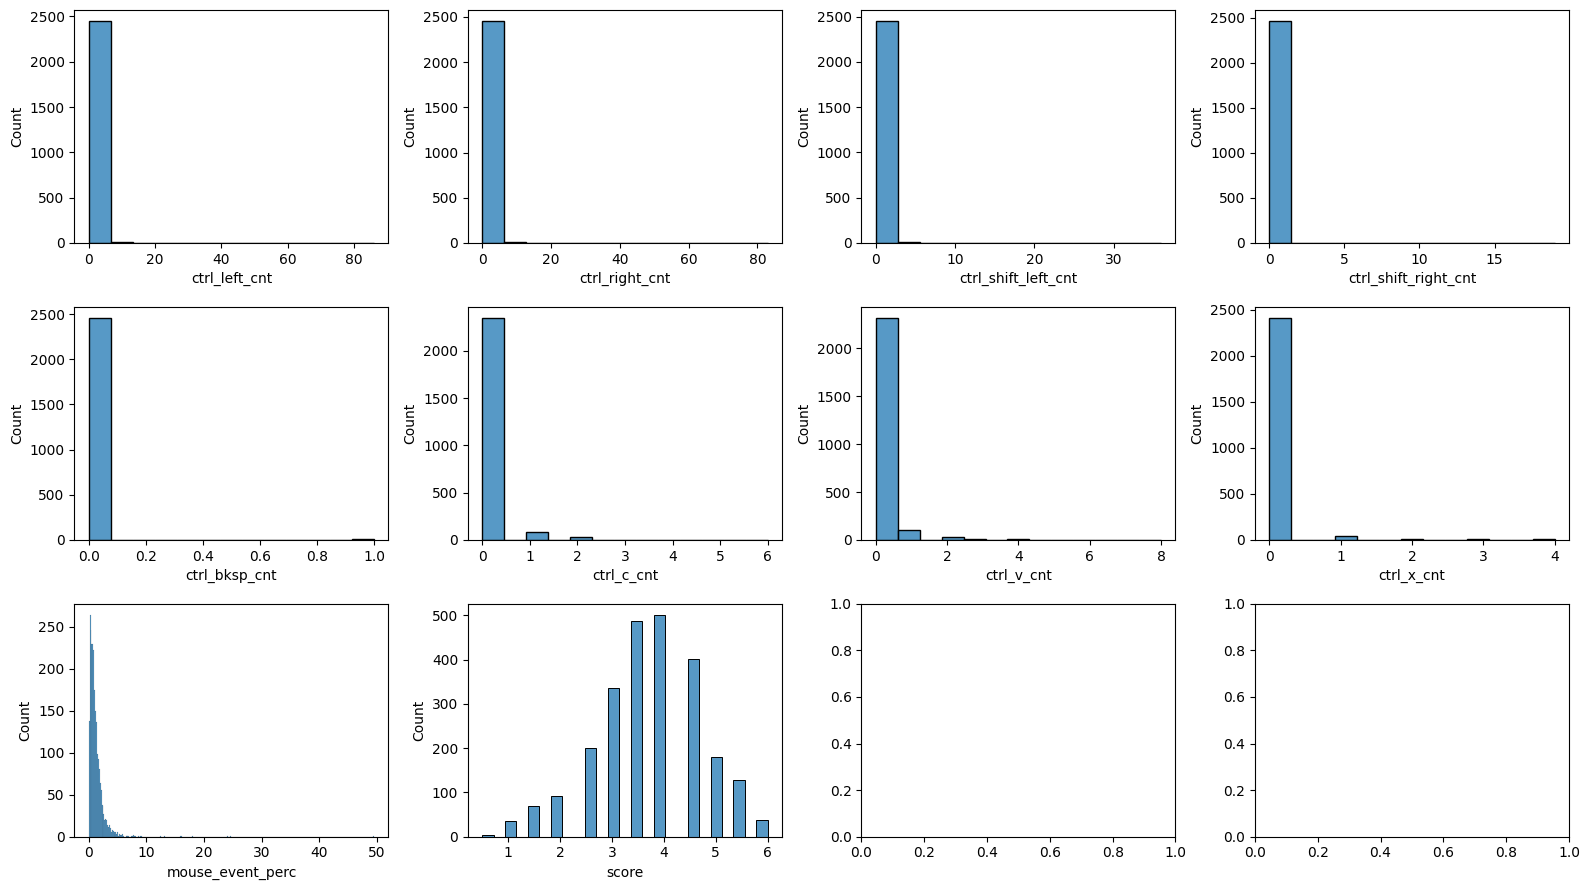

In [10]:
eda_df = ms_kb_df.set_index('id')

fig, axes = plt.subplots(nrows=math.ceil(eda_df.shape[1]/4), ncols=4, figsize=(16,9))
axes = axes.flatten()

for i, col in enumerate(eda_df.columns):
    sns.histplot(x=col, data=eda_df, ax=axes[i])
    
plt.tight_layout()
plt.show()